
## Data Cleaning and Shape Examining 


In [1]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestRegressor, BaggingRegressor
from nltk.stem.snowball import SnowballStemmer

stemmer = SnowballStemmer('english')

training_data = pd.read_csv("input/train.csv.zip", encoding="ISO-8859-1")
testing_data = pd.read_csv("input/test.csv.zip", encoding="ISO-8859-1")
attribute_data = pd.read_csv('input/attributes.csv.zip')
descriptions = pd.read_csv('input/product_descriptions.csv.zip')

training_data = pd.merge(training_data, descriptions, 
                         on="product_uid", how="left")




In [2]:
training_data.isnull().any()

id                     False
product_uid            False
product_title          False
search_term            False
relevance              False
product_description    False
dtype: bool

In [3]:
from bs4 import BeautifulSoup
import lxml
import re
import nltk
from nltk.corpus import stopwords # Import the stop word list
from nltk.metrics import edit_distance
from string import punctuation
from collections import Counter
import nltk



def remove_html_tag(text):
    soup = BeautifulSoup(text, 'lxml')
    text = soup.get_text().replace('Click here to review our return policy for additional information regarding returns', '')
    return text

def str_stemmer(doc):
    # split into tokens by white space
    tokens = doc.split()
    # remove punctuation from each token
    table = str.maketrans('', '', punctuation)
    tokens = [w.translate(table) for w in tokens]
    # remove remaining tokens that are not alphabetic
    tokens = [word for word in tokens if word.isalpha()]
    # filter out stop words
    stop_words = set(stopwords.words('english'))
    tokens = [w for w in tokens if not w in stop_words]
    # filter out short tokens
    tokens = [word for word in tokens if len(word) > 1]
    return ' '.join(tokens)

def str_stemmer_title(s):
    return " ".join([stemmer.stem(word) for word in s.lower().split()])

def str_common_word(str1, str2):
    whole_set = set(str1.split())
    return sum(int(str2.find(word)>=0) for word in whole_set)

 




In [4]:
############### cleaning html tags ##################
has_tag_in = training_data.product_description.str.contains('<br')
training_data.loc[has_tag_in, 'product_description'] = training_data.loc[has_tag_in, 'product_description'].map(lambda x:remove_html_tag(x))
###############

############## apply stemming #####################
training_data['search_term'] = training_data['search_term'].map(lambda x:str_stemmer_title(x))
training_data['product_title'] = training_data['product_title'].map(lambda x:str_stemmer(x))

training_data['product_description'] = training_data['product_description'].map(lambda x:str_stemmer(x))
############## end stemming #####################

############## building custome feature, let's build a few of them before compare which one is the best ###########
training_data['number_of_words_in_a_query'] = training_data['search_term'].map(lambda x:len(x.split())).astype(np.int64)
training_data['shared_words'] = training_data[['search_term','product_description', 'product_title']].apply(lambda row:sum([str_common_word(*row[:-1]), str_common_word(*row[1:])]), axis=1)

# training_data['frequency_digits_in_sq']=training_data.product_description.str.count("\\d+")
training_data['number_of_character_in_description'] = training_data.product_description.str.count("\\w+")
training_data["edit_distance_searchq_prod_title"] = training_data.loc[:, ["search_term","product_title"]].apply(lambda x: edit_distance(*x), axis=1)



In [5]:
training_data.isnull().any()

id                                    False
product_uid                           False
product_title                         False
search_term                           False
relevance                             False
product_description                   False
number_of_words_in_a_query            False
shared_words                          False
number_of_character_in_description    False
edit_distance_searchq_prod_title      False
dtype: bool

In [6]:
training_data[['product_title','len_of_query','shared_words','frequency_words_in_sq','relevance']].corr()

,len_of_query,shared_words,frequency_words_in_sq,relevance
len_of_query,1.000000,0.221767,0.063501,-0.072279
shared_words,0.221767,1.000000,0.339178,0.054164
frequency_words_in_sq,0.063501,0.339178,1.000000,0.040146
relevance,-0.072279,0.054164,0.040146,1.000000


In [1]:
from nltk.corpus import brown, stopwords
from nltk.cluster.util import cosine_distance
 
def sentence_similarity(sent1, sent2, stopwords=None):
    sent1 = sent1.split(' ')
    sent2 = sent2.split(' ')
    if stopwords is None:
        stopwords = []
 
    sent1 = [w.lower() for w in sent1]
    sent2 = [w.lower() for w in sent2]
 
    all_words = list(set(sent1 + sent2))
 
    vector1 = [0] * len(all_words)
    vector2 = [0] * len(all_words)
 
    # build the vector for the first sentence
    for w in sent1:
        if w in stopwords:
            continue
        vector1[all_words.index(w)] += 1
 
    # build the vector for the second sentence
    for w in sent2:
        if w in stopwords:
            continue
        vector2[all_words.index(w)] += 1
    return 1 - cosine_distance(vector1, vector2)

In [2]:
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity

def get_cosine_sim(*strs): 
    vectors = [t for t in get_vectors(*strs)]
    return cosine_similarity(vectors)
    
def get_vectors(*strs, stopwords = None):
    text = [t for t in strs]
    vectorizer = CountVectorizer(text, stop_words=stopwords) if stopwords else CountVectorizer(text)
    vectorizer.fit(text)
    return vectorizer.transform(text).toarray()


def sentence_similarity2(sent1, sent2, stopwords=None):
    r = get_vectors(sent1, sent2,stopwords) if stopwords else get_vectors(sent1, sent2)
    return 1 - cosine_distance(*r)

In [61]:
get_cosine_sim('this is hellow','asdasdasdsa')

array([[1., 0.],
       [0., 1.]])

In [5]:
%timeit -r 10 -n 1000 sentence_similarity2('this is hellow hudysiua yidsyai dyisay disay disa','this is hellow')

724 µs ± 22.7 µs per loop (mean ± std. dev. of 10 runs, 1000 loops each)


In [6]:
%timeit -r 10 -n 1000 sentence_similarity('this is hellow hudysiua yidsyai dyisay disay disa','this is hellow')

25.4 µs ± 4.08 µs per loop (mean ± std. dev. of 10 runs, 1000 loops each)


In [32]:
training_data.head()

,id,product_uid,product_title,search_term,relevance,product_description,number_of_words_in_a_query,shared_words,number_of_character_in_description,edit_distance_searchq_prod_title,sentence_similarity_search_query_with_prod_title,sentence_similarity_search_query_with_prod_desc,sentence_similarity_prod_title_with_prod_desc,search_avg,prod_title_desc
0,2,100001,Simpson StrongTie Angle,angl bracket,3.0,Not angles make joints stronger also provide c...,2,3,74,20,0.0,0.0,0.121716,5.5,0.957486


In [ ]:
training_data['sentence_similarity_search_query_with_prod_title'] = training_data.loc[:,['search_term','product_title']].apply(lambda row:sentence_similarity(*row), axis=1)
training_data['sentence_similarity_search_query_with_prod_desc'] = training_data.loc[:,['search_term','product_description']].apply(lambda row:sentence_similarity(*row), axis=1)

In [11]:
training_data['sentence_similarity_prod_title_with_prod_desc'] = training_data.loc[:,['product_title','product_description']].apply(lambda row:sentence_similarity(*row), axis=1)



In [12]:
spearman_corr = training_data.corr(method='spearman').relevance.sort_values(ascending=False)

In [13]:
spearman_corr[abs(spearman_corr)>0.03]

relevance                                           1.000000
sentence_similarity_search_query_with_prod_title    0.223372
sentence_similarity_search_query_with_prod_desc     0.170706
shared_words                                        0.045657
number_of_character_in_description                  0.042318
edit_distance_searchq_prod_title                   -0.036855
number_of_words_in_a_query                         -0.117370
id                                                 -0.126681
product_uid                                        -0.126681
Name: relevance, dtype: float64

In [12]:
spearman_corr = training_data.corr(method='spearman').relevance.sort_values(ascending=False)
spearman_corr

relevance                                           1.000000
sentence_similarity_search_query_with_prod_title    0.223372
sentence_similarity_search_query_with_prod_desc     0.170706
shared_words                                        0.045657
frequency_words_in_sq                               0.042318
distance                                           -0.036855
len_of_query                                       -0.117370
id                                                 -0.126681
product_uid                                        -0.126681
Name: relevance, dtype: float64

In [8]:
%matplotlib inline
import matplotlib.pyplot
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

In [14]:
# best = spearman_corr[abs(spearman_corr)>0.11].index.tolist()
# best.remove('id')
# best.remove('relevance')
# # scatter_matrix(train[best], alpha=0.5, figsize=(100, 50), diagonal='hist');
# matplotlib.rc('xtick', labelsize=20);
# matplotlib.rc('ytick', labelsize=20);
# fig, ax = plt.subplots(figsize=(30, 40), nrows=len(best), ncols=1)
# df = training_data.copy()
# for i, col in enumerate(best):
#     sns.boxplot(df[col], df['relevance'], width=0.5, whis=0.5, fliersize=0, ax=ax[i])
#     ax[i].set_xlabel(col, fontsize=25)
#     ax[i].set_ylabel('relevance', fontsize=25)
# plt.show()

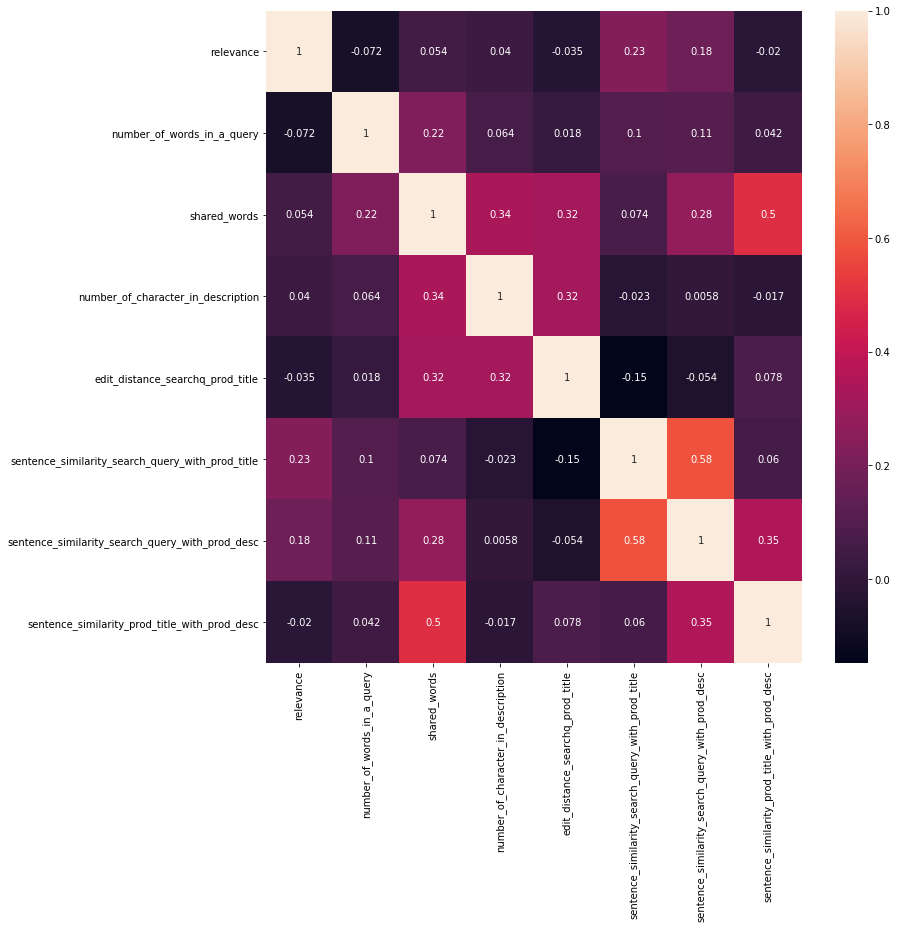

In [15]:
import seaborn as sns
plt.figure(figsize=(12, 12))
temp = training_data.drop(['product_uid','id'],axis=1)
sns.heatmap(temp.corr(), annot=True)
plt.show()

In [16]:
training_data.columns

Index(['id', 'product_uid', 'product_title', 'search_term', 'relevance',
       'product_description', 'len_of_query', 'shared_words',
       'frequency_words_in_sq', 'distance',
       'sentence_similarity_search_query_with_prod_title',
       'sentence_similarity_search_query_with_prod_desc'],
      dtype='object')

In [17]:
temp2 = training_data.drop(['id'],axis=1)[:100]



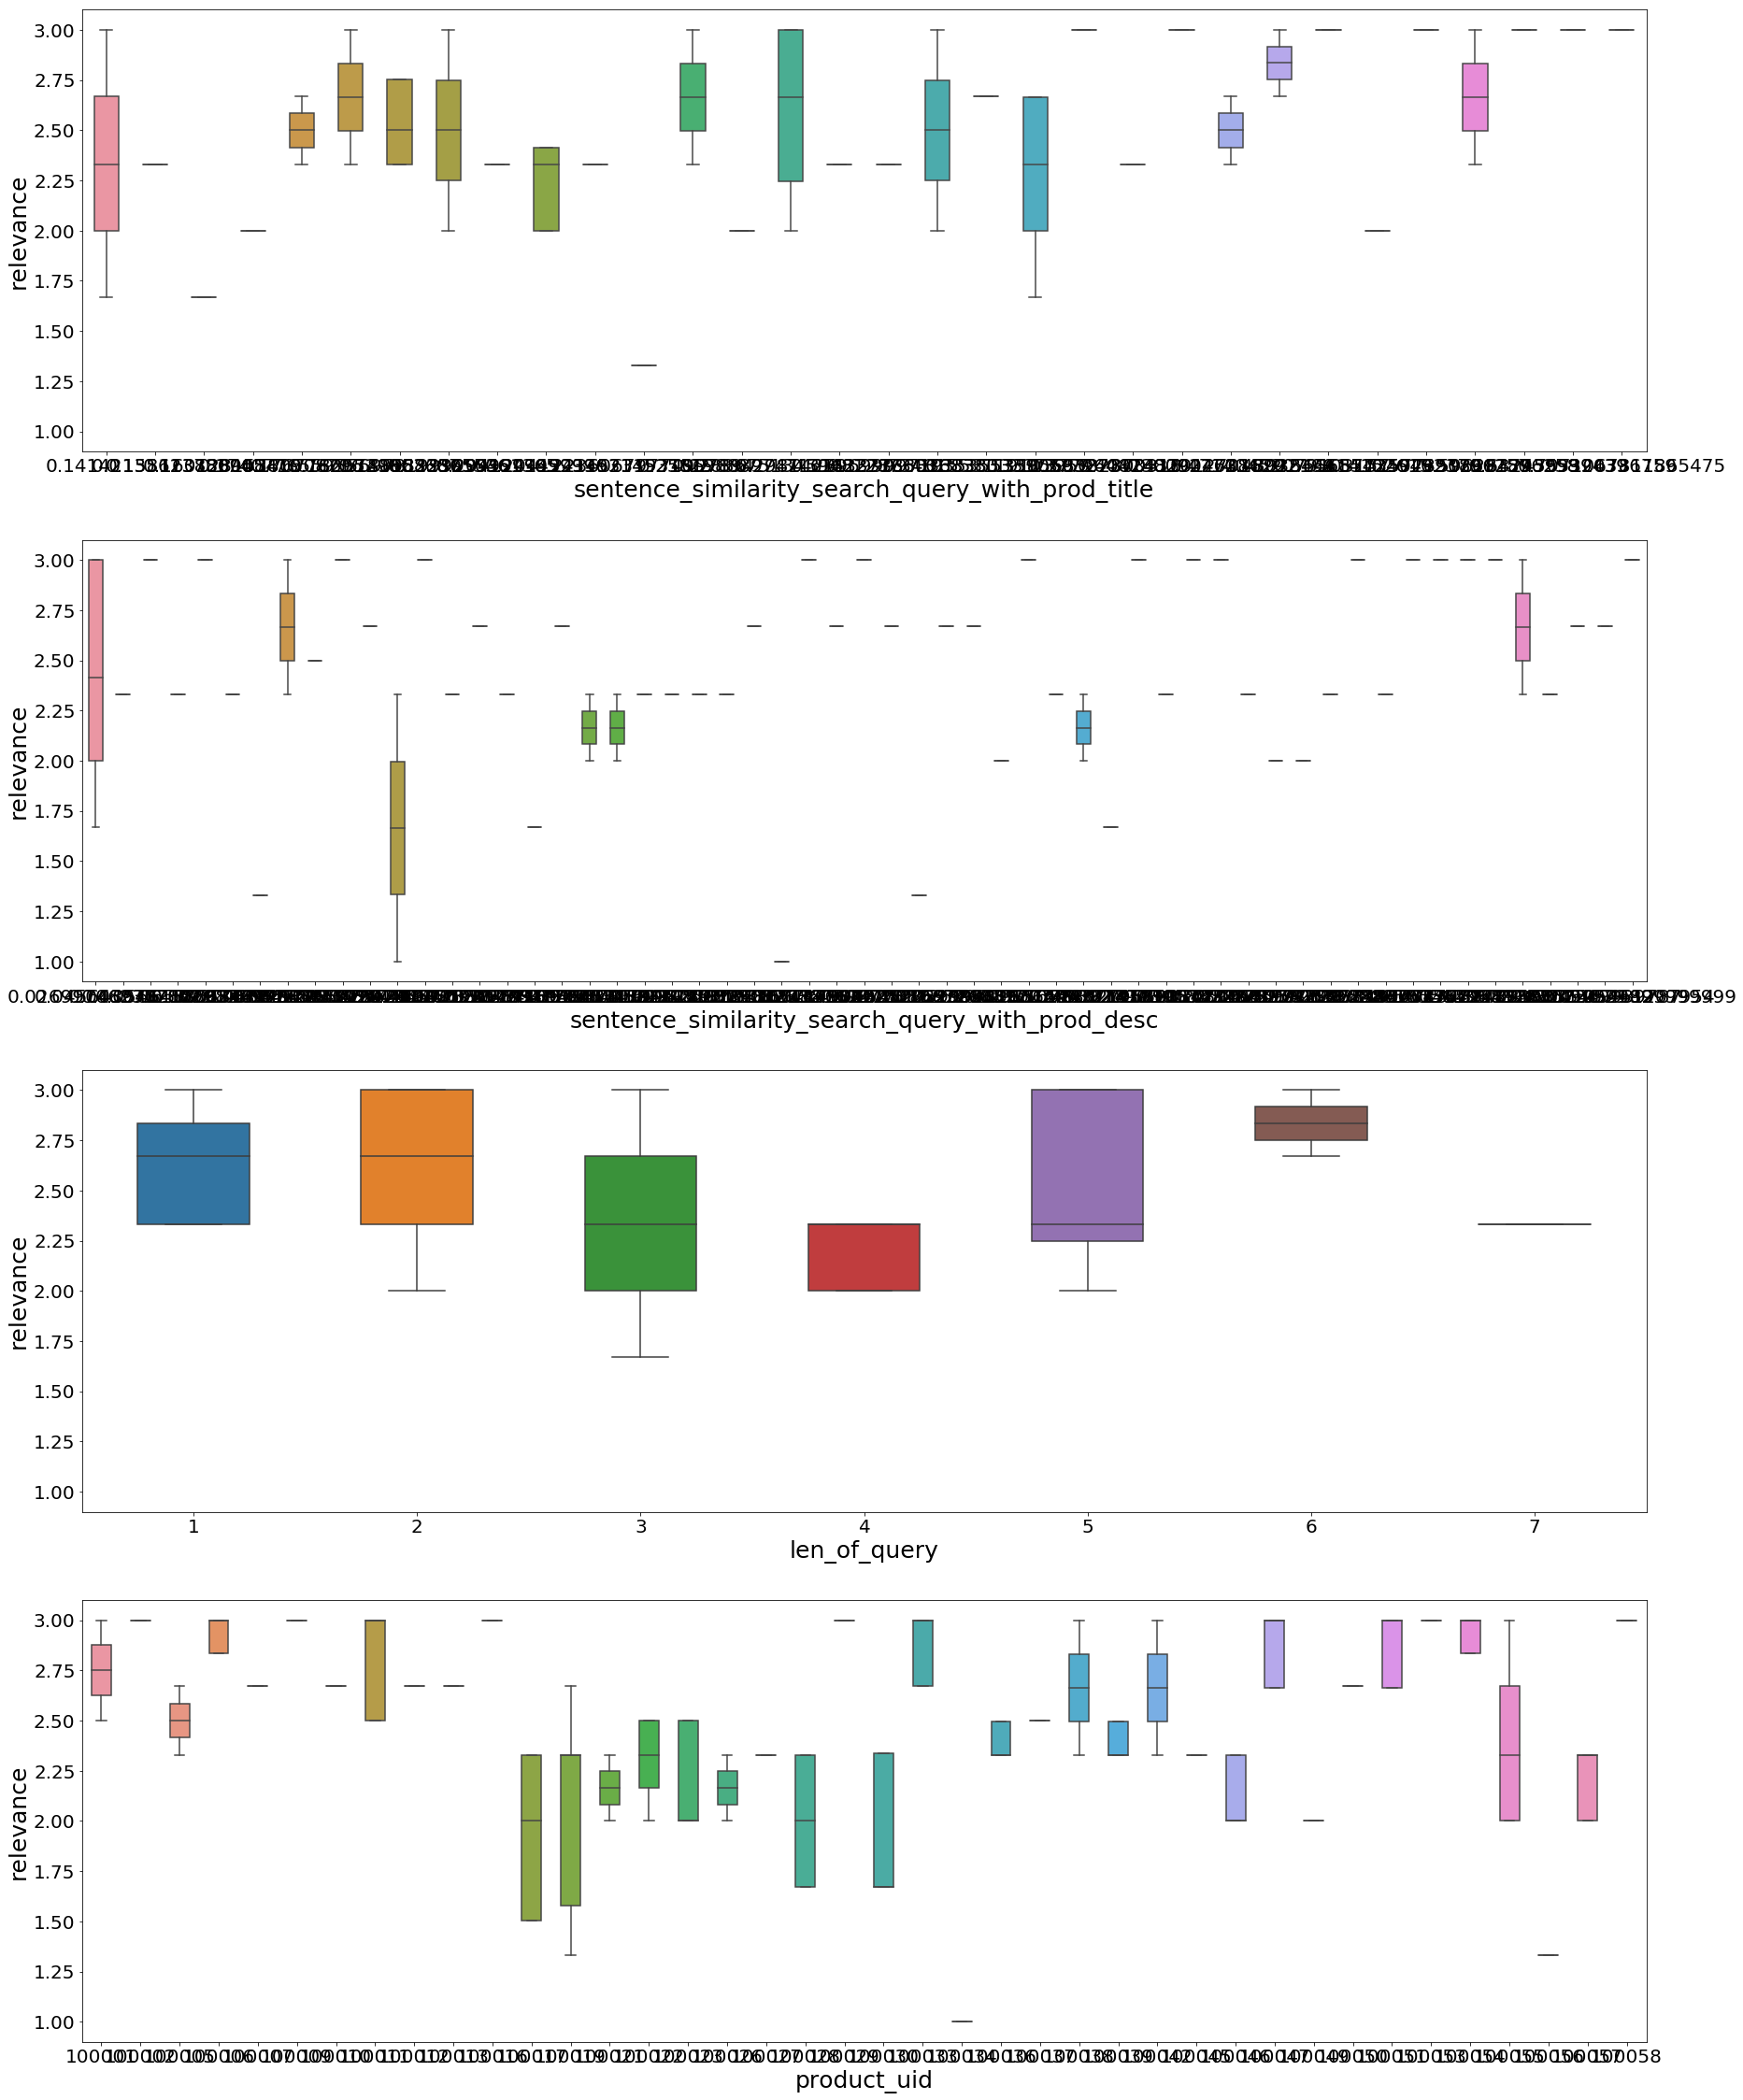

In [18]:
best = spearman_corr[abs(spearman_corr)>0.11].index.tolist()
best.remove('id')
best.remove('relevance')
# scatter_matrix(train[best], alpha=0.5, figsize=(100, 50), diagonal='hist');
matplotlib.rc('xtick', labelsize=20);
matplotlib.rc('ytick', labelsize=20);
fig, ax = plt.subplots(figsize=(30, 40), nrows=len(best), ncols=1)
df = temp2.copy()
for i, col in enumerate(best):
    sns.boxplot(df[col], df['relevance'], width=0.5, whis=0.5, fliersize=0, ax=ax[i])
    ax[i].set_xlabel(col, fontsize=25)
    ax[i].set_ylabel('relevance', fontsize=25)
plt.show()

In [19]:
full_train_df = create_dataframe(training_data[['product_uid', 'search_term', 'relevance']], train_products_dict, column_names)

NameError: name 'create_dataframe' is not defined

In [ ]:
import numpy as np

In [ ]:
training_data.corr()

/Users/iurii/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6499: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


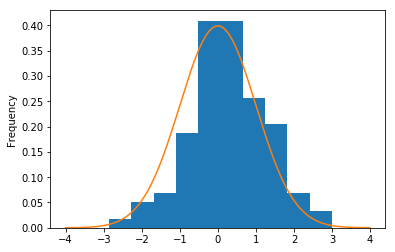

In [30]:
from scipy.stats import norm  
df = pd.DataFrame({'A': np.random.normal(size=100)})

df.A.plot(kind='hist', normed=True)

range = np.arange(-4, 4, 0.001)
plt.plot(range, norm.pdf(range,0,1))

/Users/iurii/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6499: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


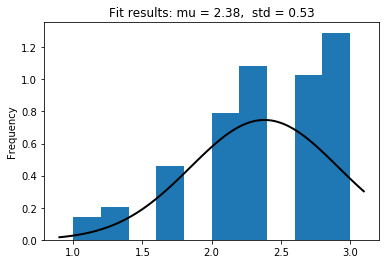

In [31]:
from scipy.stats import norm  

training_data.relevance.plot(kind='hist', normed=True)

mu, std = norm.fit(training_data.relevance)

xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mu, std)
plt.plot(x, p, 'k', linewidth=2)
title = "Fit results: mu = %.2f,  std = %.2f" % (mu, std)
plt.title(title)

plt.show()

In [ ]:
training_data.corr()

In [ ]:
df = training_data.groupby(['shared_words'])
df.head(10)

In [23]:
training_data['test'] = training_data.shared_words/training_data.

In [16]:
training_data.head(3)

,id,product_uid,product_title,search_term,relevance,product_description,number_of_words_in_a_query,shared_words,number_of_character_in_description,edit_distance_searchq_prod_title,sentence_similarity_search_query_with_prod_title,sentence_similarity_search_query_with_prod_desc,sentence_similarity_prod_title_with_prod_desc
0,2,100001,Simpson StrongTie Angle,angl bracket,3.0,Not angles make joints stronger also provide c...,2,3,74,20,0.0,0.000000,0.121716
1,3,100001,Simpson StrongTie Angle,l bracket,2.5,Not angles make joints stronger also provide c...,2,3,74,20,0.0,0.000000,0.121716
2,9,100002,BEHR Premium Textured DeckOver Tugboat Wood Co...,deck over,3.0,BEHR Premium Textured DECKOVER innovative soli...,2,6,116,53,0.0,0.056614,0.424604


In [17]:
def avg_word(sentence):
  words = sentence.split()
  return (sum(len(word) for word in words)/len(words))

In [ ]:
training_data['search_avg'] = training_data.search_term.apply(avg_word)

In [28]:
training_data['prod_title_desc'] = training_data.loc[:,['product_title','product_description','shared_words']].apply(lambda row:avg_word(row[0])/avg_word(row[1]),axis=1)

In [29]:
training_data.corr()

,id,product_uid,relevance,number_of_words_in_a_query,shared_words,number_of_character_in_description,edit_distance_searchq_prod_title,sentence_similarity_search_query_with_prod_title,sentence_similarity_search_query_with_prod_desc,sentence_similarity_prod_title_with_prod_desc,search_avg,prod_title_desc
id,1.000000,0.986738,-0.116426,0.192900,-0.036805,-0.067528,0.044136,0.059717,-0.022325,-0.006326,-0.021505,0.007207
product_uid,0.986738,1.000000,-0.130656,0.206109,-0.033058,-0.062033,0.045716,0.050041,-0.029056,-0.009155,-0.020615,0.006723
relevance,-0.116426,-0.130656,1.000000,-0.072279,0.054164,0.040146,-0.034573,0.233916,0.176779,-0.019797,0.062487,0.018581
number_of_words_in_a_query,0.192900,0.206109,-0.072279,1.000000,0.221767,0.063501,0.017572,0.099975,0.110122,0.042022,-0.288377,-0.029275
shared_words,-0.036805,-0.033058,0.054164,0.221767,1.000000,0.339178,0.320273,0.074324,0.277038,0.495262,-0.039232,-0.007215
number_of_character_in_description,-0.067528,-0.062033,0.040146,0.063501,0.339178,1.000000,0.317115,-0.022591,0.005794,-0.017008,0.041169,0.043668
edit_distance_searchq_prod_title,0.044136,0.045716,-0.034573,0.017572,0.320273,0.317115,1.000000,-0.147653,-0.053929,0.077861,0.013362,0.173470
sentence_similarity_search_query_with_prod_title,0.059717,0.050041,0.233916,0.099975,0.074324,-0.022591,-0.147653,1.000000,0.584507,0.060049,0.017114,-0.122883
sentence_similarity_search_query_with_prod_desc,-0.022325,-0.029056,0.176779,0.110122,0.277038,0.005794,-0.053929,0.584507,1.000000,0.345481,-0.036337,-0.023667
sentence_similarity_prod_title_with_prod_desc,-0.006326,-0.009155,-0.019797,0.042022,0.495262,-0.017008,0.077861,0.060049,0.345481,1.000000,-0.025400,-0.014567
